#  EMBEDDED SYSTEMS (EEL3090) || COURSE PROJECT
**Somshuvra Basu (B21EE069) & Uppala Giridhar (B21EE072)**


*IMPORTING NECCESSARY LIBRARIES*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchmetrics.image import StructuralSimilarityIndexMeasure
from torchmetrics.image import PeakSignalNoiseRatio
from __future__ import print_function
import numpy as np
from scipy.signal import savgol_filter
from six.moves import xrange
import umap
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision.utils import make_grid

2024-05-05 09:28:18.039026: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 09:28:18.039144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 09:28:18.309119: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from torchmetrics.image import StructuralSimilarityIndexMeasure
from pathlib import Path
from torchmetrics.image import PeakSignalNoiseRatio

In [3]:
import cv2  as cv
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition as skd
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

*DATASET PATH. WE HAVE CHOOSED "Kodak" DATASET*

In [4]:
directory = "/kaggle/input/kodak-dataset"

*NECCESSARY HYPARPARAMETERS*

In [5]:
input_size = 256 * 256 * 3  
latent_dim = 64 
batch_size = 3 
epochs = 50 

*NECESSARY TRANSFORMS*

In [6]:
transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor(), 
])

*A CUSTOM CLASS TO LOAD THE KODAK DATASET*

In [7]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = os.listdir(root_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


*LOAD THE DATASET AND SETUP DATALOADERS*

In [8]:
data_dir = '/kaggle/input/kodak-dataset'
dataset = ImageDataset(root_dir=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

*PLOT THE FIRST 5 IMAGES OF DATASET*

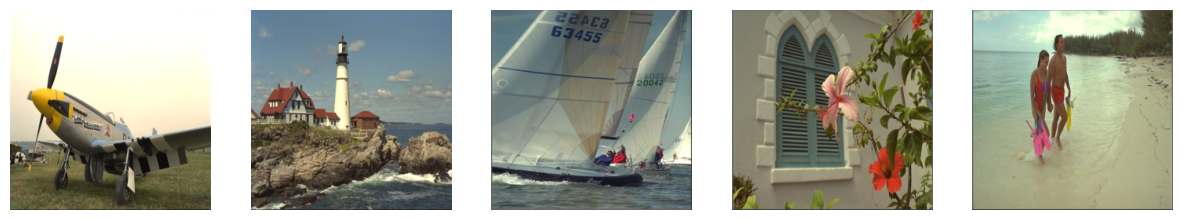

In [9]:

fig, axes = plt.subplots(1, 5, figsize=(15, 3))  

for i in range(5):
    image = dataset[i]  
    axes[i].imshow(image.permute(1, 2, 0)) 
    axes[i].axis('off') 

plt.show()


# USING PCA (Principal Component Analysis)

In [49]:
img=cv.cvtColor(cv.imread('/kaggle/input/pca-compression/Soyuz.jpg'),cv.COLOR_BGR2RGB)

In [50]:
def PCAcompress(img, percentage):
    r, g, b = cv.split(img)
    r, g, b = r/255, g/255, b/255
    pca_components = int(percentage*min(r.shape))
    pca_r = skd.PCA(n_components=pca_components) 
    reduced_r=pca_r.fit_transform(r)

    pca_g = skd.PCA(n_components=pca_components)
    reduced_g=pca_g.fit_transform(g)

    pca_b = skd.PCA(n_components=pca_components)
    reduced_b=pca_b.fit_transform(b)

    combined=np.array([reduced_r, reduced_g, reduced_b])

    reconstructed_r=pca_r.inverse_transform(reduced_r)
    reconstructed_g=pca_g.inverse_transform(reduced_g)
    reconstructed_b=pca_b.inverse_transform(reduced_b)

    img_reconstructed=np.dstack((reconstructed_r, reconstructed_g, reconstructed_b))

    img_reconstructed = np.clip(img_reconstructed, 0, 1)
    
    return img_reconstructed

In [51]:
def plot_images(img, img_reconstructed):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    ax[1].imshow(img_reconstructed)
    ax[1].set_title('Reconstructed Image')
    ax[1].axis('off')
    plt.show()

In [52]:
def save_images(img, img_reconstructed, percentage):
    cv.imwrite(f'Reconstructed_{percentage}.png', cv.cvtColor((img_reconstructed*255).astype(np.uint8), cv.COLOR_RGB2BGR))

In [53]:
img_recon=PCAcompress(img, 0.8)

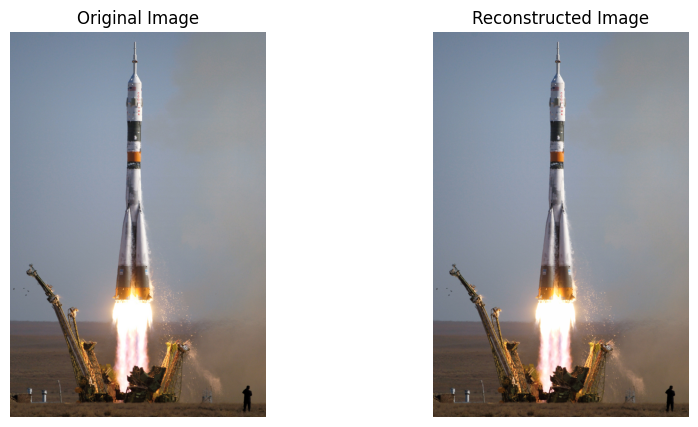

In [54]:
plot_images(img, img_recon)

In [55]:
save_images(img, img_recon, 0.8)

# MODEL 1: AUTOENCODER

*DEFINING THE AUTOENCODER MODEL CLASS*

In [17]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder_in = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.encoder_block = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.encoder_layers = nn.ModuleList([
            self._create_encoder_block() for _ in range(3)  
        ])
        self.encoder_out = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)

        self.decoder_in = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1) 
        self.decoder_block = nn.Sequential(
            nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True)
        )
        self.decoder_layers = nn.ModuleList([
            self._create_decoder_block() for _ in range(3)  
        ])
        self.decoder_out = nn.ConvTranspose2d(16, 3, kernel_size=3, padding=1)

    def _create_encoder_block(self):
        return nn.Sequential(
            self.encoder_block,
            nn.Conv2d(16, 16, kernel_size=3, padding=1)  
        )

    def _create_decoder_block(self):
        return nn.Sequential(
            self.decoder_block,
            nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1)  
        )

    def forward(self, x):
      
        residual = self.encoder_in(x)
        for block in self.encoder_layers:
            out = block(residual)
            residual = residual + out  
        out = self.encoder_out(residual)

        residual = self.decoder_in(out)
        for block in self.decoder_layers:
            out = block(residual)
            residual = residual + out  
        out = self.decoder_out(residual)
        return out

In [18]:
model = Autoencoder()

In [19]:
print(model)

Autoencoder(
  (encoder_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_block): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (encoder_layers): ModuleList(
    (0-2): 3 x Sequential(
      (0): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (encoder_out): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (decoder_in): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (decoder_block): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (decoder_layers): ModuleList(
    (0-2): 3 x Sequential(
      (0): Sequential(
        (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), paddi

*TRAINING THE AUTOENCODER MODEL*

In [20]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):
    for data in dataloader:
        
        output = model(data)
        loss = criterion(output, data[:, :, :-1, :-1])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

torch.save(model.state_dict(), 'autoencoder_model.pth')

with torch.no_grad():
    for data in dataloader:
        output = model(data)
        torchvision.utils.save_image(output, 'reconstructed_images.png')
        break 

Epoch [1/50], Loss: 0.0377
Epoch [2/50], Loss: 0.0133
Epoch [3/50], Loss: 0.0106
Epoch [4/50], Loss: 0.0061
Epoch [5/50], Loss: 0.0058
Epoch [6/50], Loss: 0.0054
Epoch [7/50], Loss: 0.0027
Epoch [8/50], Loss: 0.0029
Epoch [9/50], Loss: 0.0040
Epoch [10/50], Loss: 0.0021
Epoch [11/50], Loss: 0.0023
Epoch [12/50], Loss: 0.0016
Epoch [13/50], Loss: 0.0027
Epoch [14/50], Loss: 0.0014
Epoch [15/50], Loss: 0.0011
Epoch [16/50], Loss: 0.0011
Epoch [17/50], Loss: 0.0017
Epoch [18/50], Loss: 0.0014
Epoch [19/50], Loss: 0.0009
Epoch [20/50], Loss: 0.0015
Epoch [21/50], Loss: 0.0013
Epoch [22/50], Loss: 0.0011
Epoch [23/50], Loss: 0.0012
Epoch [24/50], Loss: 0.0010
Epoch [25/50], Loss: 0.0011
Epoch [26/50], Loss: 0.0008
Epoch [27/50], Loss: 0.0009
Epoch [28/50], Loss: 0.0009
Epoch [29/50], Loss: 0.0012
Epoch [30/50], Loss: 0.0008
Epoch [31/50], Loss: 0.0006
Epoch [32/50], Loss: 0.0006
Epoch [33/50], Loss: 0.0007
Epoch [34/50], Loss: 0.0009
Epoch [35/50], Loss: 0.0006
Epoch [36/50], Loss: 0.0006
E

*CHECKING THE COMPRESSION FACTOR OF THE IMAGE*

In [22]:
for data in dataloader:
    sample_image = data[0]
    compressed_image = model(sample_image)
    break

compressed_image_pil = transforms.ToPILImage()(compressed_image.cpu().detach())
compressed_image_pil.save('/kaggle/working/output_image_1.jpg')

sample_image_pil = transforms.ToPILImage()(sample_image.cpu().detach())
sample_image_pil.save('/kaggle/working/input_image_1.jpg')

image_path = Path('/kaggle/working/input_image_1.jpg')
sample_image_size = os.path.getsize(image_path)

image_path = Path('/kaggle/working/output_image_1.jpg')
compressed_image_size = os.path.getsize(image_path)

compression_factor = sample_image_size / compressed_image_size

print("Compression Factor:", compression_factor)

Compression Factor: 1.0138169257340242


The Compression factor achieved is very less. So, there is no point in using this model. So, let's move on to the next model.

# MODEL 2: VQ - VAE

*VECTOR QUANTIZED VARIATIONAL AUTOENCODER*

In [23]:
class VQVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, embed_dim, num_embeddings, commitment_cost):
        super(VQVAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.embed_dim = embed_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost

        self.encoder = nn.Sequential(
            nn.Conv2d(3, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, embed_dim, kernel_size=1)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embed_dim, hidden_dim, kernel_size=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim, 3, kernel_size=4, stride=2, padding=1)
        )

        self.embedding = nn.Embedding(num_embeddings, embed_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)        

    def forward(self, x):
   
        enc = self.encoder(x)
        enc_shape = enc.shape
        enc = enc.view(-1, self.embed_dim)

        quantized, quantized_idx = self.quantize(enc)
        quantized = quantized.view(enc_shape)
        dec = self.decoder(quantized)

        return dec, quantized, quantized_idx

    def quantize(self, x):
    
        x = x.unsqueeze(0)
        x = x.reshape(-1, self.input_dim, self.embed_dim)
        
        distances = (x - self.embedding.weight).norm(dim=1)  

        encoding_indices = distances.argmin(dim=1) 
        quantized = self.embedding(encoding_indices)  

        quantized = quantized.unsqueeze(1)

        loss = F.mse_loss(quantized.detach(), x) 
        quantized = x + (quantized - x).detach() 

        return quantized, encoding_indices

*TRAINING VQ-VAE*

In [24]:
vq_vae = VQVAE(input_dim=256, hidden_dim=128, embed_dim=128, num_embeddings=256, commitment_cost=0.5)

criterion = nn.MSELoss()
optimizer = optim.Adam(vq_vae.parameters(), lr=0.001)

In [25]:
epochs = 50

In [37]:
for epoch in range(epochs):
    for data in dataloader:
        output, quantized, _ = vq_vae(data)
        loss = criterion(output, data)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

/tmp/ipykernel_34/1658567946.py:57: UserWarning: Using a target size (torch.Size([12, 256, 128])) that is different to the input size (torch.Size([12, 1, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(quantized.detach(), x)


Epoch [1/50], Loss: 0.0612
Epoch [2/50], Loss: 0.0384
Epoch [3/50], Loss: 0.0496
Epoch [4/50], Loss: 0.0312
Epoch [5/50], Loss: 0.0537
Epoch [6/50], Loss: 0.0311
Epoch [7/50], Loss: 0.0876
Epoch [8/50], Loss: 0.0508
Epoch [9/50], Loss: 0.0876
Epoch [10/50], Loss: 0.0406
Epoch [11/50], Loss: 0.0400
Epoch [12/50], Loss: 0.0367
Epoch [13/50], Loss: 0.0419
Epoch [14/50], Loss: 0.0376
Epoch [15/50], Loss: 0.0548
Epoch [16/50], Loss: 0.0432
Epoch [17/50], Loss: 0.0445
Epoch [18/50], Loss: 0.0465
Epoch [19/50], Loss: 0.0341
Epoch [20/50], Loss: 0.0371
Epoch [21/50], Loss: 0.0912
Epoch [22/50], Loss: 0.0253
Epoch [23/50], Loss: 0.0934
Epoch [24/50], Loss: 0.0484
Epoch [25/50], Loss: 0.0569
Epoch [26/50], Loss: 0.0311
Epoch [27/50], Loss: 0.0376
Epoch [28/50], Loss: 0.0323
Epoch [29/50], Loss: 0.0343
Epoch [30/50], Loss: 0.0318
Epoch [31/50], Loss: 0.0471
Epoch [32/50], Loss: 0.0812
Epoch [33/50], Loss: 0.0353
Epoch [34/50], Loss: 0.0439
Epoch [35/50], Loss: 0.0431
Epoch [36/50], Loss: 0.0342
E

In [38]:
torch.save(vq_vae.state_dict(), 'vqvae_model.pth')

*COMPARING ORIGINAL AND COMPRESSED IMAGE*

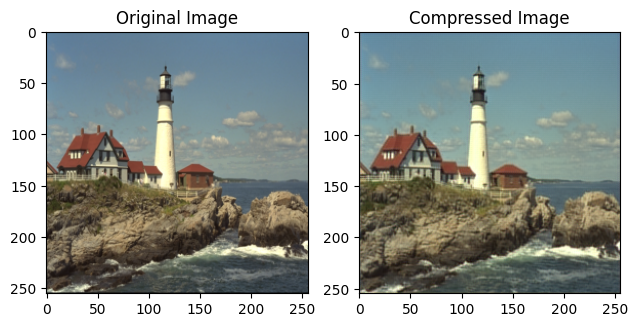

In [39]:
def plot_image(image):
  plt.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())

with torch.no_grad():
  for data in dataloader:
    sample_image = data[0] 

    plt.subplot(121) 
    plot_image(sample_image)
    plt.title('Original Image')

    compressed_image = model(sample_image)

    plt.subplot(122)  
    plot_image(compressed_image)
    plt.title('Compressed Image')

    plt.tight_layout() 
    plt.show()

    break 

*CALCULATING COMPRESSION FACTOR...*

In [40]:
for data in dataloader:
    sample_image = data[0]
    compressed_image, _, _ = vq_vae(sample_image)
    break

compressed_image_pil = transforms.ToPILImage()(compressed_image.cpu().detach())
compressed_image_pil.save('/kaggle/working/output_image_1_vqvae.jpg')

sample_image_pil = transforms.ToPILImage()(sample_image.cpu().detach())
sample_image_pil.save('/kaggle/working/input_image_1_vqvae.jpg')

image_path = Path('/kaggle/working/input_image_1_vqvae.jpg')
sample_image_size = os.path.getsize(image_path)

image_path = Path('/kaggle/working/output_image_1_vqvae.jpg')
compressed_image_size = os.path.getsize(image_path)

compression_factor = sample_image_size / compressed_image_size

print("Compression Factor:", compression_factor)

Compression Factor: 3.737327188940092


/tmp/ipykernel_34/1658567946.py:57: UserWarning: Using a target size (torch.Size([4, 256, 128])) that is different to the input size (torch.Size([4, 1, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(quantized.detach(), x)


In [41]:
def check_size(loader):
  for each in loader:
    x_ = each
    print(x_.shape)
    break

In [42]:
check_size(dataloader)

torch.Size([3, 3, 256, 256])


In [43]:
len(dataloader)

8

*CALCULATING SSIM AND PSNR VALUES FOR THE COMPRESSED IMAGES*

In [44]:
ssim = StructuralSimilarityIndexMeasure()
psnr = PeakSignalNoiseRatio()

In [45]:
SSIM = []
PSNR = []

In [46]:
with torch.no_grad():
  for batch in dataloader:
    for image in batch:
        sample_image = image
        compressed_image = model(sample_image)
        original_image = sample_image[:, :255, :255] 
        compressed_image = compressed_image[:,  :255, :255]
        original_image = original_image.unsqueeze(0)  
        compressed_image = compressed_image.unsqueeze(0)
        ssim_value = ssim(original_image, compressed_image)
        psnr_value = psnr(original_image, compressed_image)
        SSIM.append(ssim_value)
        PSNR.append(psnr_value)

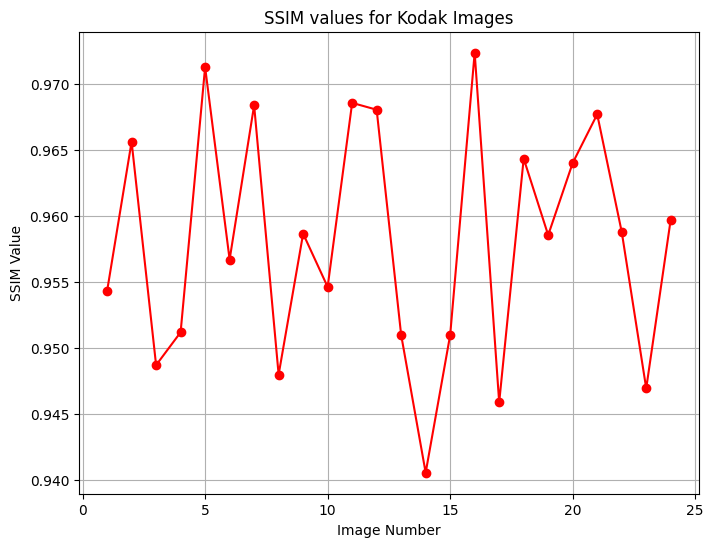

In [47]:
x_values = list(range(1, 25))
plt.figure(figsize=(8, 6)) 
plt.plot(x_values, SSIM , marker='o', color='red', linestyle='-')

plt.title('SSIM values for Kodak Images')
plt.xlabel('Image Number')
plt.ylabel('SSIM Value')

plt.grid(True)
plt.show()


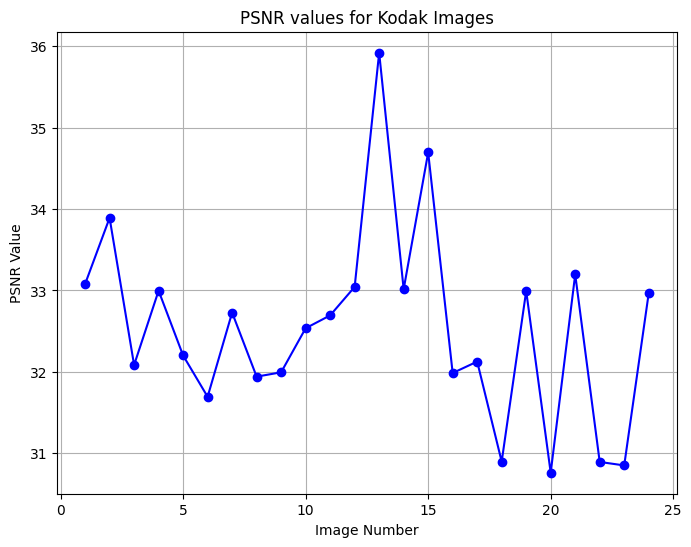

In [48]:
x_values = list(range(1, 25))
plt.figure(figsize=(8, 6)) 
plt.plot(x_values, PSNR , marker='o', color='blue', linestyle='-')

plt.title('PSNR values for Kodak Images')
plt.xlabel('Image Number')
plt.ylabel('PSNR Value')

plt.grid(True)
plt.show()